#RNN (recurrent neural networks)

In [127]:
import pandas as pd
import re
import string
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [128]:
reviews_df = pd.read_csv('/content/reviews.csv')
reviews_df

,id,text
0,168,"Hi Leah, I ordered this early to give to a co-..."
1,26,"Good evening, \n I just received my order! I ..."
2,64,I couldn’t find where I could write a review b...
3,10,I received my order today and gave it to my si...
4,111,"﻿Max,\n\nWe received the heart but sadly are d..."
...,...,...
249,189,"Thank you, this is beautiful and they loved it."
250,72,Thanks so much. They lookgreat!
251,107,"Emily, \n THANK YOU so much for the new “bric..."
252,271,"Jacqueline, \n I just received the replaceme..."


In [129]:
labels_df = pd.read_csv('/content/labels.csv')
labels_df

,id,sentiment
0,168,Positive
1,26,Positive
2,64,Positive
3,10,Positive
4,111,Negative
...,...,...
249,189,Positive
250,72,Positive
251,107,Positive
252,271,Positive


In [130]:
# Merge the two dataframes on the 'id' column to add the 'sentiment' as 'target' in reviews
reviews_df = reviews_df.merge(labels_df.rename(columns={'sentiment': 'target'}), on='id', how='left')
dt = reviews_df.copy()

In [131]:
dt.drop(columns=['id'], inplace=True)

In [132]:
dt

,text,target
0,"Hi Leah, I ordered this early to give to a co-...",Positive
1,"Good evening, \n I just received my order! I ...",Positive
2,I couldn’t find where I could write a review b...,Positive
3,I received my order today and gave it to my si...,Positive
4,"﻿Max,\n\nWe received the heart but sadly are d...",Negative
...,...,...
249,"Thank you, this is beautiful and they loved it.",Positive
250,Thanks so much. They lookgreat!,Positive
251,"Emily, \n THANK YOU so much for the new “bric...",Positive
252,"Jacqueline, \n I just received the replaceme...",Positive


In [133]:
#Перевіримо, який % пропущених значень
def count_missings(dt):
    missing_values = dt.isnull().sum()
    missing_percentage = (missing_values / len(dt)) * 100
    missing_dt = pd.concat([missing_values, missing_percentage], axis=1)
    missing_dt.columns = ['Missing Count', 'Missing %']
    missing_dt_sorted = missing_dt[missing_dt['Missing %'] > 0.01].sort_values(by='Missing %', ascending=False)

    return missing_dt_sorted

count_missings(dt)

,Missing Count,Missing %


In [134]:
#Видалимо пропущені значення
dt_cleaned = dt.dropna(subset=['text'])
dt_cleaned.isnull().sum()

,0
text,0
target,0


#Data Preprocessing

In [135]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [136]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import nltk

# Завантаження стоп-слів
nltk.download('stopwords')

# Видалення пропущених значень
dt_cleaned = dt.dropna(subset=['text']).reset_index(drop=True)

# Ініціалізація лематизатора і стоп-слів
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Функція очищення тексту
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+|https?://\S+|www\.\S+', '', text)  # Видалення URL
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Видалення пунктуації
    text = re.sub(r'\s+', ' ', text).strip()  # Видалення зайвих пробілів
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Очищення текстів
dt_cleaned['text'] = dt_cleaned['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [137]:
# Агументація тексту (перестановка слів)
def augment_text(text):
    words = text.split()
    if len(words) > 1:
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Створення агументованого набору
dt_augmented = dt_cleaned.copy()
dt_augmented['text'] = dt_augmented['text'].apply(augment_text)

# Об'єднання оригінального і аргументованого наборів
dt_combined = pd.concat([dt_cleaned, dt_augmented]).reset_index(drop=True)

In [138]:
# Підготовка міток і токенізація
X = dt_combined['text']
y = dt_combined['target']

In [139]:
# Токенізація тексту
max_words = 10000
max_len = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_len)

In [140]:
# Кодування міток
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [141]:
# Розділення на навчальний і тестовий набори
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_categorical, test_size=0.2, random_state=42
)

In [142]:
print("Розмір навчального набору (X_train):", X_train.shape)
print("Розмір тестового набору (X_test):", X_test.shape)
print("Розмір навчальних міток (y_train):", y_train.shape)
print("Розмір тестових міток (y_test):", y_test.shape)

Розмір навчального набору (X_train): (406, 50)
Розмір тестового набору (X_test): (102, 50)
Розмір навчальних міток (y_train): (406, 2)
Розмір тестових міток (y_test): (102, 2)


#Create model fron scratch

In [143]:
# Параметри
embedding_dim = 128
num_classes = 2
learning_rate = 0.001  # Оптимізований коефіцієнт навчання

# Побудова моделі
model = Sequential([
    Input(shape=(50,)),  # Явний вхідний шар
    Embedding(input_dim=10000, output_dim=embedding_dim),
    Dropout(0.2),
    LSTM(128, return_sequences=True),  # Перший LSTM шар
    Dropout(0.2),
    LSTM(64),                          # Другий LSTM шар
    Dropout(0.2),                      # Збільшений Dropout для регуляризації
    Dense(num_classes, activation='softmax')  # Вихідний шар
])

# Оптимізатор із оптимізованим learning rate
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=learning_rate)

# Компіляція моделі
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Перевірка структури моделі
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 50, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 50, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,461,122 (5.57 MB)

 Trainable params: 1,461,122 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Навчання моделі
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,  # Оптимізований розмір партії
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.5966 - loss: 0.6710 - val_accuracy: 0.6275 - val_loss: 0.6370
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.6734 - loss: 0.6229 - val_accuracy: 0.8627 - val_loss: 0.5569
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9178 - loss: 0.4767 - val_accuracy: 0.8824 - val_loss: 0.3337
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9548 - loss: 0.1721 - val_accuracy: 0.9608 - val_loss: 0.1386
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.9908 - loss: 0.0537 - val_accuracy: 0.9510 - val_loss: 0.1228
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.9964 - loss: 0.0121 - val_accuracy: 0.9608 - val_loss: 0.0661
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9804 - val_loss: 0.0455
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.9981 - loss: 0.0136 - val_accuracy: 0.9608 - val_loss:

In [145]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точність на тестовому наборі: {test_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9692 - loss: 0.0642
Точність на тестовому наборі: 0.98


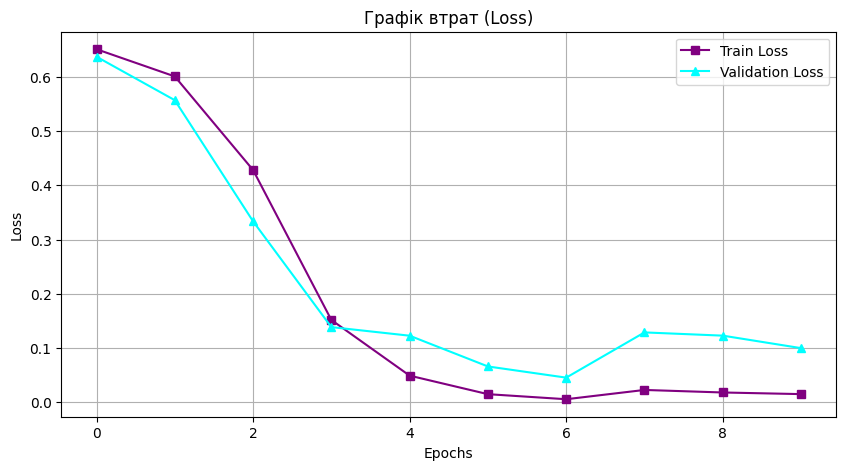

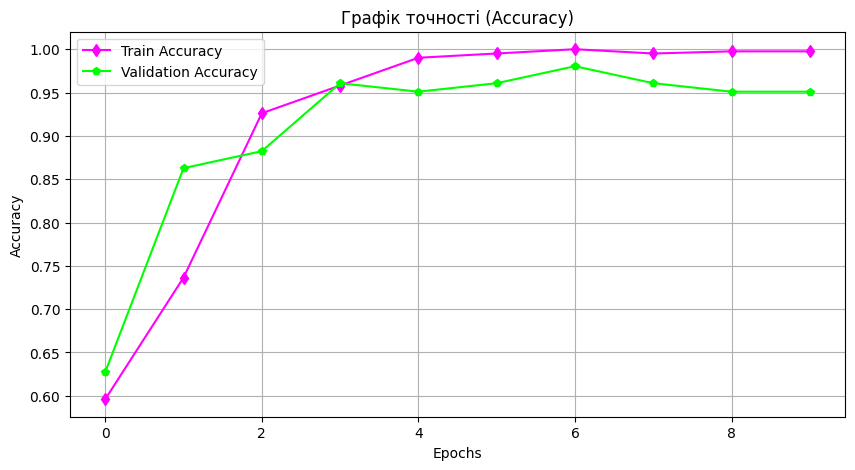

In [146]:
import matplotlib.pyplot as plt

# Візуалізація втрат
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='purple', marker='s')  # Фіолетовий і квадратні маркери
plt.plot(history.history['val_loss'], label='Validation Loss', color='cyan', marker='^')  # Блакитний і трикутні маркери
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Графік втрат (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Візуалізація точності
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='magenta', marker='d')  # Малиновий і ромбовидні маркери
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='lime', marker='p')  # Лаймовий і п'ятикутні маркери
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Графік точності (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

In [148]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [149]:
y_test_a = np.argmax(y_test, axis=1)
y_pred_a = np.argmax(model.predict(X_test), axis=1)

# Перевірка точності
accuracy = accuracy_score(y_test_a, y_pred_a)
print(f"Model Accuracy: {accuracy:.2f}")

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
Model Accuracy: 0.98


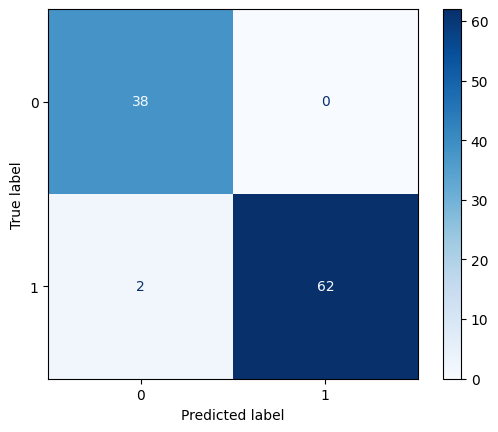

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Матриця плутанини
conf_matrix = confusion_matrix(y_test_a, y_pred_a)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Blues")

# Показати графік
plt.show()

In [151]:
print("Розмір навчального набору (X_train):", X_train.shape)
print("Розмір тестового набору (X_test):", X_test.shape)
print("Розмір навчальних міток (y_train):", y_train.shape)
print("Розмір тестових міток (y_test):", y_test.shape)

Розмір навчального набору (X_train): (406, 50)
Розмір тестового набору (X_test): (102, 50)
Розмір навчальних міток (y_train): (406, 2)
Розмір тестових міток (y_test): (102, 2)


#Using Pretrained Word Embeddings

In [152]:
embedding_path = "glove.6B.100d.txt"

# Завантаження ембедінгів GloVe у словник
embeddings_index = {}
with open(embedding_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Завантажено {len(embeddings_index)} слів із GloVe.")

Завантажено 160672 слів із GloVe.


In [153]:
word_index = tokenizer.word_index
num_tokens = len(word_index) + 2
embedding_dim = 100  #Використовуємо файл 6В.100d
hits = 0
misses = 0

# Створюємо ембедінгову матрицю
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Конвертовано %d слів (%d пропусків)" % (hits, misses))

Конвертовано 1668 слів (279 пропусків)


In [154]:
missing_words = [word for word, i in word_index.items() if embeddings_index.get(word) is None]
print("Пропущені слова:", missing_words[:50])

Пропущені слова: ['it’s', 'i’m', 'don’t', 'that’s', 'can’t', 'couldn’t', 'didn’t', '❤️', 'doesn’t', 'i’ll', 'son’s', '\ufeff', 'thankyou', 'she’s', '1lt', 'c2isr', 'i’d', 'image1jpeg', 'isn’t', 'couldnt', 'who’s', 'brianmouth', 'mailmobileaolcom', '“brick”', 'withyou', 'wouldnt', 'على', 'it”', '👍', 'it’ll', 'psychometrist', '7635345911', 'he’s', 'wasn’t', '\ufeffmax', '5897820054', 'image0jpeg', '182020', '12”', 'recibe', 'ordervery', 'disappointedpaid', 'dothe', 'rotaiting', 'ligth', 'paíd', 'dólaresno', 'retorned', 'justwanted', 'saythankyou']


In [155]:
print("Розмір навчального набору (X_train):", X_train.shape)
print("Розмір тестового набору (X_test):", X_test.shape)
print("Розмір навчальних міток (y_train):", y_train.shape)
print("Розмір тестових міток (y_test):", y_test.shape)

Розмір навчального набору (X_train): (406, 50)
Розмір тестового набору (X_test): (102, 50)
Розмір навчальних міток (y_train): (406, 2)
Розмір тестових міток (y_test): (102, 2)


In [159]:
# Параметри
embedding_dim = 100  # Розмір GloVe-ембедінгів
num_classes = 2
learning_rate = 0.001

# Побудова моделі
embed_model = Sequential([
    Input(shape=(50,)),  # Явний вхідний шар
    Embedding(
        input_dim=num_tokens,          # Розмір словника
        output_dim=embedding_dim,      # Розмір ембедінгів
        weights=[embedding_matrix],    # Використовуємо GloVe-матрицю
        trainable=False
    ),
    LSTM(128, return_sequences=True),  # Перший LSTM шар
    Dropout(0.2),
    LSTM(64),                          # Другий LSTM шар
    Dropout(0.2),                      # Збільшений Dropout для регуляризації
    Dense(num_classes, activation='softmax')  # Вихідний шар
])

# Оптимізатор із оптимізованим learning rate
optimizer = Adam(learning_rate=learning_rate)

# Компіляція моделі
embed_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Перевірка структури моделі
embed_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 50, 100)             │         194,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 50, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 361,686 (1.38 MB)

 Trainable params: 166,786 (651.51 KB)

 Non-trainable params: 194,900 (761.33 KB)

In [160]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback: ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback: Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [161]:
# Навчання моделі
embed_history = embed_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 121s 19s/step - accuracy: 0.5496 - loss: 0.6763 - val_accuracy: 0.7255 - val_loss: 0.5493 - learning_rate: 0.0010
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.8036 - loss: 0.4885 - val_accuracy: 0.8039 - val_loss: 0.3794 - learning_rate: 0.0010
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.8312 - loss: 0.4141 - val_accuracy: 0.8137 - val_loss: 0.3437 - learning_rate: 0.0010
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.8826 - loss: 0.2878 - val_accuracy: 0.8824 - val_loss: 0.2991 - learning_rate: 0.0010
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9372 - loss: 0.1872 - val_accuracy: 0.8824 - val_loss: 0.2713 - learning_rate: 0.0010
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.9480 - loss: 0.1690 - val_accuracy: 0.8824 - val_loss: 0.3167 - learning_rate: 0.0010
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.9397 - loss: 0.1492 - val_accuracy: 

In [169]:
test_loss, test_accuracy = embed_model.evaluate(X_test, y_test)
print(f"Точність на тестовому наборі: {test_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8592 - loss: 0.3126
Точність на тестовому наборі: 0.88


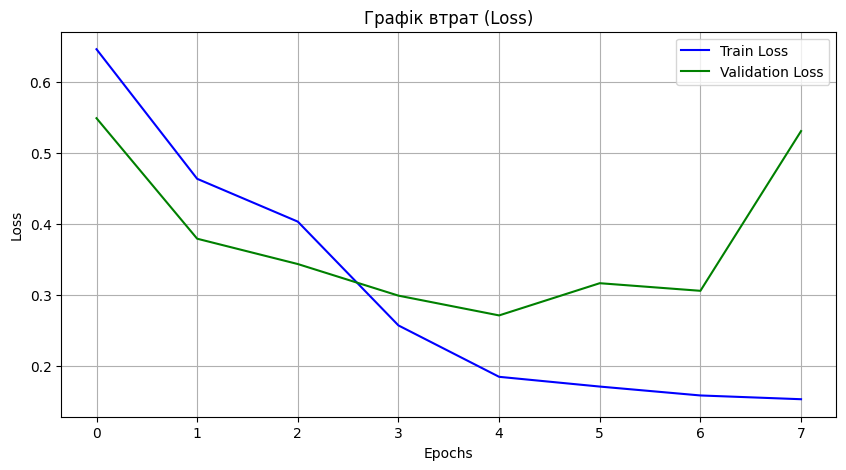

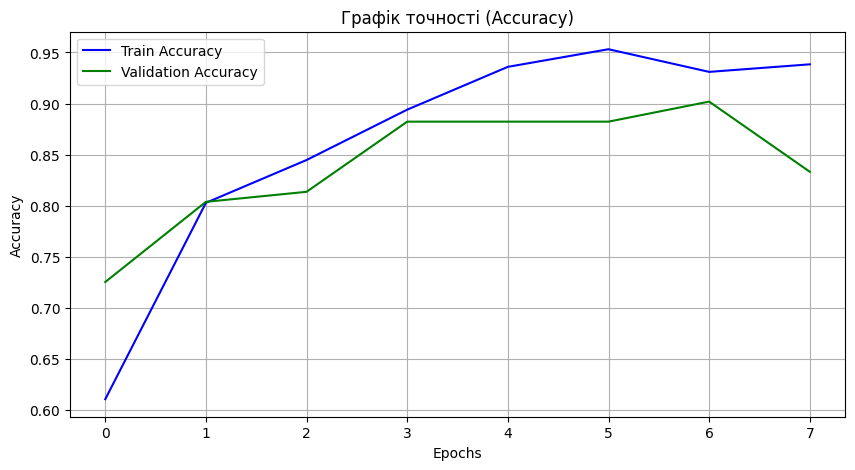

In [167]:
import matplotlib.pyplot as plt

# Візуалізація втрат
plt.figure(figsize=(10, 5))
plt.plot(embed_history.history['loss'], label='Train Loss', color='blue')
plt.plot(embed_history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Графік втрат (Loss)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(embed_history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(embed_history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Графік точності (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

In [168]:
y_test_em = np.argmax(y_test, axis=1)
y_pred_em = np.argmax(model.predict(X_test), axis=1)

# Перевірка точності
accuracy = accuracy_score(y_test_em, y_pred_em)
print(f"Model Accuracy: {accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Model Accuracy: 0.98


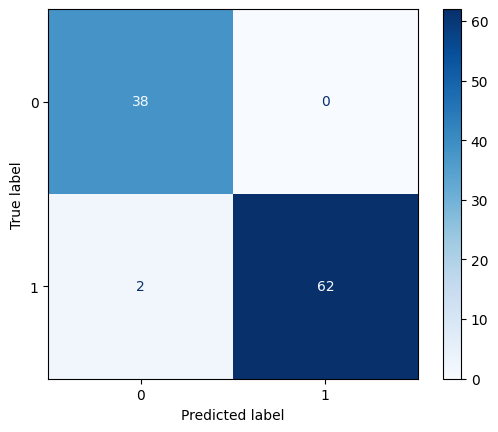

In [170]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Матриця плутанини
conf_matrix = confusion_matrix(y_test_em, y_pred_em)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Blues")

# Показати графік
plt.show()

#В першому випадку модель показала кращий результат. Але стандартні алгоритми все одна показали навіть відмінний результат, такы як: Decision tree та AdaBoost.